This is a example of two DoF Duffing oscillator:

The following nonlinear equation of motion is solve:

$$
\begin{align}
m_1 \ddot{x}_1 + c_1 \dot{x}_1 + c_2 \dot{x}_1  - c_2 \dot{x}_2 + k_1 x_1 + k_2 x_1  - k_2 x_2   & = 0 \\
m_2 \ddot{x}_2 - c_2 \dot{x}_1 + c_2 \dot{x}_2 - k_2 x_1 + k_2 x_2 + \beta(x_2)^3   & = P cos( \omega t)
\end{align}
$$

Where $m_1 = m_2 = 1 kg$, $c1 = c2= = 0.05 Ns/m $  , $k_1 = k_2 = 1.0 N/m$, $P = 1 N $ and $\beta = 1.0 N/m^3$ 

Rewritten the two above equation in matrix notation we get:

\begin{equation*}
\begin{bmatrix}
m_1 & 0 \\
0 & m_2 
\end{bmatrix}
\begin{bmatrix}
\ddot{x}_1 \\
\ddot{x}_2
\end{bmatrix}
+
\begin{bmatrix}
c_1 + c_2 & -c_2 \\
-c_2 & c_2 
\end{bmatrix}
\begin{bmatrix}
\dot{x}_1 \\
\dot{x}_2
\end{bmatrix}
+
\begin{bmatrix}
k_1 + k_2  & -k_2 \\
-k_2 & k_2 
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix}
+
\begin{bmatrix}
0 \\
f^{NL}_2(x_1,x_2)
\end{bmatrix}
=
\begin{bmatrix}
0 \\
P cos( \omega t)
\end{bmatrix}
\end{equation*}

Where  $f^{NL}_2(x_1,x_2)= \beta (x_2)^3$ 

In compact matrix notation notation we have:

$$
M \ddot{x} + C \dot{x} + K x + f^{NL}(x) = f^L
$$

Where $f^L$ is the vector function $ [ 0, P cos( \omega t) ]^T $ and $f^{NL}(x)$ is defined as:

$$
f^{NL}(x) = \beta H ( B^{\Delta} x)^3
$$ 

where $H$ is the matrix:
$$
H = 
\begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
$$

and $B^{\Delta}$ is 

\begin{equation*}
B^{\Delta} = 
\begin{bmatrix}
0 & 0 \\
0 & 1
\end{bmatrix}
\end{equation*}


If we apply a Fourier Transform $\mathscr{F}$ in the above system we have:
$$
Z( \omega ) \tilde{x} + \tilde{f}^{NL} (\tilde{x}) - \tilde{f}^L = 0
$$

where 
$$
Z( \omega ) = -\omega^2 M + j \omega C + K
$$

$$
\tilde{f}^L = [P,0]^T
$$

$$
\tilde{f}^{NL}(\tilde{x}) = \mathscr{F}(f^{NL}(\mathscr{F}^{-1}(\tilde{x})))
$$

In [18]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from contpy import frequency
from contpy import optimize
from contpy import operators
from contpy.cases.case2 import name, n_dofs, K,M,C,P,beta, B_delta, H


def Booleanintime(B,Itime):
    BB = np.kron(Itime,B[:,0])
    for i in range(1,B.shape[0]):
        BB = np.vstack((BB,np.kron(Itime,B[:,i])))
    return BB

In [24]:
#HBM variables
nH = 1
n_points = 200

# buiding Harmonic bases and the Augmented force vector amplitude
Q = frequency.assemble_HBMOperator(n_dofs,number_of_harm=nH ,n_points=n_points)
P_aug = list(0*P)*nH
P_aug[0:n_dofs] = list(P)
P_aug = np.array(P_aug)
fl = Q.dot(P_aug).real

# building Residual equation for continuation
beta = 0.1
fl_ = Q.H.dot(fl) # force in frequency domain
fnl = lambda u : beta*H@(B_delta.dot(u)**3)
fnl_ = lambda u_ : Q.H.dot(fnl(Q.dot(u_))) - fl_
Z = lambda w : frequency.create_Z_matrix(K,C,M,f0= w/(2.0*np.pi),nH=nH)
R = lambda u_, w : Z(w).dot(u_) + fnl_(u_)

# build force nonlineat
Ro = operators.ReshapeOperator(n_dofs,n_points)
Itime = np.eye(n_points)
#BB = Booleanintime(B_delta,Itime)
BB = np.kron(B_delta,Itime)
HH = np.kron(H,Itime)
fnl_void = lambda u : beta*HH@((BB.dot(u))**3)
fnl__void = lambda u_ : Q.H.Q.dot(fnl_void(Q.Q.dot(u_).real)) - fl_
Jfln_num = optimize.real_jacobian(fnl_void)
Jfln_ana = lambda uv : 3*beta*HH@np.diag(BB.dot(uv)**2)

Jfln_v_num = optimize.real_jacobian(fnl__void)
Jfln_v_ana = lambda u_ : Q.H.Q@Jfln_ana(Q.Q.dot(u_).real)@Q.Q.real


#comptuting analytical derivatives
JZw = lambda w : frequency.assemble_jacobian_Zw_matrix(K,C,M,f0= w/(2.0*np.pi),nH=nH)
Jfnl = lambda u : 3*beta*HH@np.diag(BB.dot(Ro.T.dot(u))**2)
Jfln_ = lambda u_ :  Q.H.Q@Jfnl(Q.dot(u_).real)@Q.Q
JRu_ = lambda w : lambda u_ :  Z(w) + Jfln_v_ana(u_)
JRw = lambda u_ : lambda w : np.array([[JZw(w).dot(u_)]])

# computing numerical jacobian
JRw_num = lambda u_ : optimize.real_jacobian(lambda w : R(u_,w))
#JRu_num = lambda w : optimize.complex_jacobian(lambda u_ : R(u_,w))
JRu_num = lambda w : optimize.complex_jacobian(lambda u_ : R(u_,w))
Jfln__num = optimize.complex_jacobian(fnl_ )

<IPython.core.display.Javascript object>


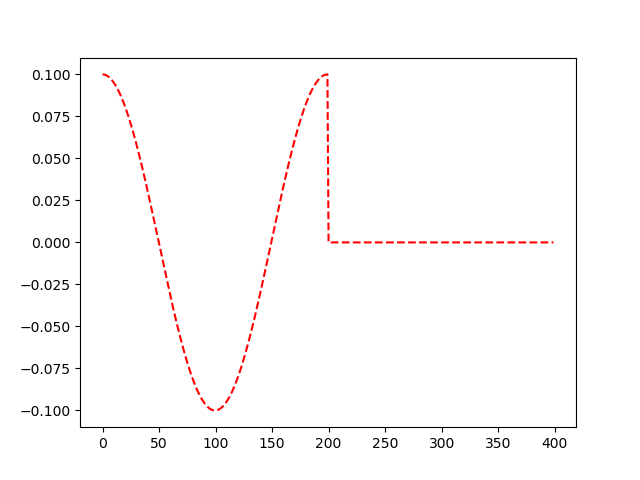

C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [25]:
plt.figure()
plt.plot(Q.Q.toarray()[:,0],'r--')


In [ ]:
#test Jacobian JRu_
u_ = np.random.rand(n_dofs*nH*2)
u_.dtype=np.complex
w0 = 10*np.random.rand()

In [ ]:
u = Q.dot(u_)

In [ ]:
uv = Q.Q.dot(u_).real

In [ ]:
u

In [ ]:
uv

In [ ]:
B_delta

In [ ]:
BB

In [ ]:
Q.H.dot(fnl(u))

In [ ]:
Q.H.Q.dot(fnl_void(uv))

In [ ]:
fnl_(u_) # force in frequency using block u in time

In [ ]:
fnl__void(u_) # force in frequency using voigt notation for u in time

In [ ]:
fnl_(u_) - fnl__void(u_)  

In [ ]:
fnl(u) # force in time using block u in time

In [ ]:
fnl_void(uv) # force in time using voigt notation u in time

In [ ]:
Jfln_num(uv)

In [ ]:
Jfln_ana(uv)

In [ ]:
np.abs(Jfln_num(uv) - Jfln_ana(uv)).max()

In [ ]:
np.abs(Jfln_num(uv) - Jfln_ana(uv)).max()

In [ ]:
Jfln_v_num(u_)

In [ ]:
Jfln_v_ana(u_) 

In [ ]:
(Jfln_v_ana(u_) - Jfln_v_num(u_)).real

In [ ]:
(Jfln_v_ana(u_) - Jfln_v_num(u_)).imag

In [ ]:
np.abs(Jfln_v_ana(u_) - Jfln_v_num(u_)).max()

In [ ]:
Q.H.Q@Jfnl(Q.dot(u_).real)@Q.Q.real

In [ ]:
Q.H.Q@Q.Q.toarray()

In [26]:
%%time
# solving continuation with numerical derivatives
x0 = np.array([0.0]*n_dofs*nH,dtype=np.complex)
y_d, p_d, info_dict = optimize.continuation(R,x0=x0,p_range=(0.01,3), p0=0.1, correction_method='matcont',
                                            max_int=200, max_dp=0.05,step=0.5, max_int_corr=20, tol=1.0E-10,
                                            print_mode=True)


Iteration 3 has converged , p = 0.13591
Iteration 4 has converged , p = 0.16457
Iteration 7 has converged , p = 0.20988
Iteration 8 has converged , p = 0.24470
Iteration 11 has converged , p = 0.27307
Iteration 12 has converged , p = 0.29687
Iteration 14 has converged , p = 0.33518
Iteration 15 has converged , p = 0.36499
Iteration 16 has converged , p = 0.40918
Iteration 17 has converged , p = 0.44093
Iteration 18 has converged , p = 0.46523
Iteration 19 has converged , p = 0.48468
Iteration 20 has converged , p = 0.50079
Iteration 21 has converged , p = 0.51451
Iteration 22 has converged , p = 0.52647
Iteration 23 has converged , p = 0.53710
Iteration 24 has converged , p = 0.54670
Iteration 25 has converged , p = 0.55551
Iteration 26 has converged , p = 0.56368
Iteration 27 has converged , p = 0.57135
Iteration 28 has converged , p = 0.57860
Iteration 29 has converged , p = 0.58553
Iteration 30 has converged , p = 0.59218
Iteration 31 has converged , p = 0.59861
Iteration 32 has con

<IPython.core.display.Javascript object>


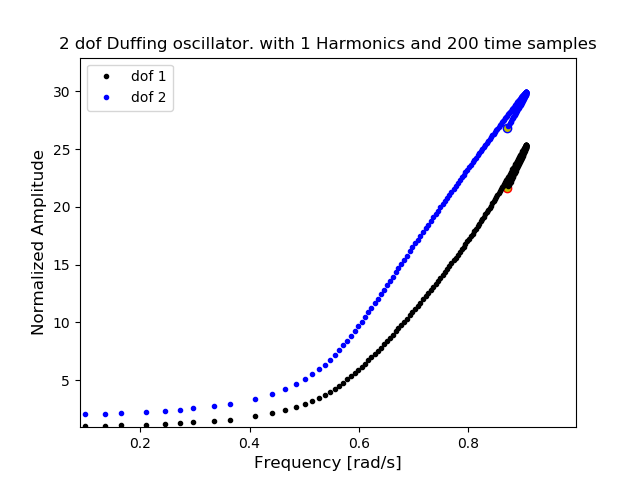

C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [27]:
fig, ax1 = plt.subplots(1)
max_x = np.abs(p_d).max()
min_x = np.abs(p_d).min()
max_y = np.abs(y_d[:]).max()
min_y = np.abs(y_d[:]).min()

factor = 0.1
lim = lambda x, factor  : x + np.sign(x)*factor*x

ax1.set_xlim([lim(min_x,-factor)   ,lim(max_x,factor)])
ax1.set_ylim([lim(min_y,-factor)   ,lim(max_y,factor)])


def update(i):
    ax1.clear()
    ax1.plot(p_d[i],np.abs(y_d[0][i]),'ro',markerfacecolor='y')
    ax1.plot(p_d[:i],np.abs(y_d[0][:i]),'k.',label='dof 1')
    ax1.plot(p_d[i],np.abs(y_d[1][i]),'bo',markerfacecolor='y')
    ax1.plot(p_d[:i],np.abs(y_d[1][:i]),'b.', label='dof 2')
    ax1.set_xlim([lim(min_x,-factor)   ,lim(max_x,factor)])
    ax1.set_ylim([lim(min_y,-factor)   ,lim(max_y,factor)])
    ax1.set_xlabel('Frequency [rad/s]', fontsize=12)
    ax1.set_ylabel('Normalized Amplitude', fontsize=12)
    ax1.set_title('%s with %i Harmonics and %i time samples' %(name,nH,n_points), fontsize=12)
    ax1.legend()
    
#ani = FuncAnimation(fig, update, frames=np.arange(0, len(p_d) ,1 ), blit=True, interval=1)   
update(len(p_d)-1)

if False:
    Writer = animation.writers['imagemagick']
    writer = Writer(fps=30, metadata=dict(artist='Guilherme Jenovencio'), bitrate=1800)

    ani.save('2dof_couple_duffing_ocsillator_v2.gif', dpi=200, writer=writer)

In [28]:
%%time
# solving continuation with analytical derivatives
x0 = np.array([0.0]*n_dofs*nH,dtype=np.complex)
y_d, p_d, info_dict = optimize.continuation(R,x0=x0,p_range=(0.01,3), p0=0.1, correction_method='matcont',
                                            jacx=JRu_,#jacp=JRw,
                                            max_int=200, max_dp=0.05,step=0.5, max_int_corr=20, tol=1.0E-10,
                                            print_mode=True)

Iteration 3 has converged , p = 0.13592
Iteration 4 has converged , p = 0.16458
Iteration 7 has converged , p = 0.20991
Iteration 8 has converged , p = 0.24473
Iteration 11 has converged , p = 0.27311
Iteration 12 has converged , p = 0.29692
Iteration 14 has converged , p = 0.33525
Iteration 15 has converged , p = 0.36507
Iteration 16 has converged , p = 0.40931
Iteration 17 has converged , p = 0.44111
Iteration 18 has converged , p = 0.46545
Iteration 19 has converged , p = 0.48495
Iteration 20 has converged , p = 0.50111
Iteration 21 has converged , p = 0.51489
Iteration 22 has converged , p = 0.52690
Iteration 23 has converged , p = 0.53758
Iteration 24 has converged , p = 0.54724
Iteration 25 has converged , p = 0.55610
Iteration 27 has converged , p = 0.56028
Iteration 30 has converged , p = 0.56232
Iteration 31 has converged , p = 0.56432
Iteration 35 has converged , p = 0.56531
Iteration 36 has converged , p = 0.56629
Iteration 40 has converged , p = 0.56727
Iteration 41 has con

<IPython.core.display.Javascript object>


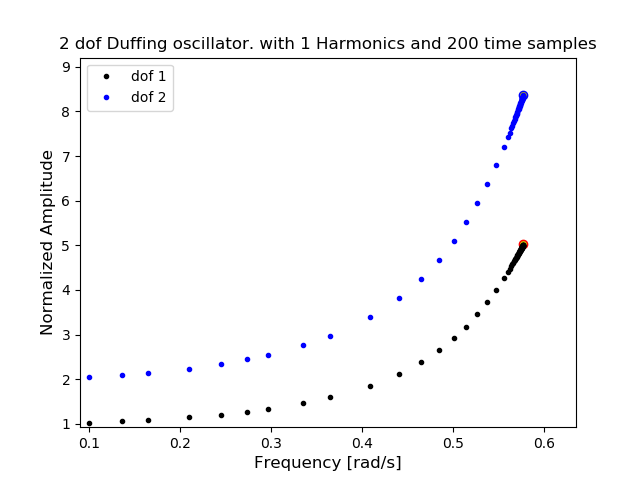

C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [29]:
fig, ax1 = plt.subplots(1)
max_x = np.abs(p_d).max()
min_x = np.abs(p_d).min()
max_y = np.abs(y_d[:]).max()
min_y = np.abs(y_d[:]).min()

factor = 0.1
lim = lambda x, factor  : x + np.sign(x)*factor*x

ax1.set_xlim([lim(min_x,-factor)   ,lim(max_x,factor)])
ax1.set_ylim([lim(min_y,-factor)   ,lim(max_y,factor)])


def update(i):
    ax1.clear()
    ax1.plot(p_d[i],np.abs(y_d[0][i]),'ro',markerfacecolor='y')
    ax1.plot(p_d[:i],np.abs(y_d[0][:i]),'k.',label='dof 1')
    ax1.plot(p_d[i],np.abs(y_d[1][i]),'bo',markerfacecolor='y')
    ax1.plot(p_d[:i],np.abs(y_d[1][:i]),'b.', label='dof 2')
    ax1.set_xlim([lim(min_x,-factor)   ,lim(max_x,factor)])
    ax1.set_ylim([lim(min_y,-factor)   ,lim(max_y,factor)])
    ax1.set_xlabel('Frequency [rad/s]', fontsize=12)
    ax1.set_ylabel('Normalized Amplitude', fontsize=12)
    ax1.set_title('%s with %i Harmonics and %i time samples' %(name,nH,n_points), fontsize=12)
    ax1.legend()
    
#ani = FuncAnimation(fig, update, frames=np.arange(0, len(p_d) ,1 ), blit=True, interval=1)   
update(len(p_d)-1)

if False:
    Writer = animation.writers['imagemagick']
    writer = Writer(fps=30, metadata=dict(artist='Guilherme Jenovencio'), bitrate=1800)

    ani.save('2dof_couple_duffing_ocsillator_v2.gif', dpi=200, writer=writer)